
Our dataset consists of clinical data from patients who entered the hospital complaining of chest pain ("angina") during exercise.  The information collected includes:

* `age` : Age of the patient

* `sex` : Sex of the patient

* `cp` : Chest Pain type

    + Value 0: asymptomatic
    + Value 1: typical angina
    + Value 2: atypical angina
    + Value 3: non-anginal pain
   
    
* `trtbps` : resting blood pressure (in mm Hg)

* `chol` : cholesterol in mg/dl fetched via BMI sensor

* `restecg` : resting electrocardiographic results

    + Value 0: normal
    + Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    + Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* `thalach` : maximum heart rate achieved during exercise

* `output` : the doctor's diagnosis of whether the patient is at risk for a heart attack
    + 0 = not at risk of heart attack
    + 1 = at risk of heart attack

In [26]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_predict

In [27]:
import warnings
warnings.filterwarnings("ignore")

In [28]:
ha = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
ha.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


In [29]:
X = ha.drop(["cp"], axis = 1)
y= ha['cp']

## Q1: Natural Multiclass Models

Fit a multiclass KNN, Decision Tree, and LDA for the heart disease data; this time predicting the type of chest pain (categories 0 - 3) that a patient experiences.  For the decision tree, plot the fitted tree, and interpret the first couple splits.


In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np

In [31]:
ct2 = ColumnTransformer(
  [
    ("standardize",
        StandardScaler(),
        ['age', 'trtbps', 'chol', 'thalach'])
  ],
  remainder = "passthrough"
)

KNN

In [33]:
knn_pipeline = Pipeline(
  [
      ("preprocessing", ct2),
      ("knn_classifier", KNeighborsClassifier())]
)

neighbors_range = np.arange(1, 10)

param = {
    'knn_classifier__n_neighbors': neighbors_range
}

gscv = GridSearchCV(knn_pipeline, param, cv=5, scoring='accuracy')

# Fit the GridSearchCV object
gscv_fitted = gscv.fit(X, y)

# Get the best score and the best parameters
best_score = gscv_fitted.best_score_
best_params = gscv_fitted.best_params_

best_score, best_params

(0.5240404040404041, {'knn_classifier__n_neighbors': 9})

In [34]:
knn_pipeline = Pipeline(
  [
      ("preprocessing", ct2),
      ("knn_classifier", KNeighborsClassifier(n_neighbors=9))]
)

# Fit and predict
knn_pipeline.fit(X, y)
y_pred_knn = cross_val_predict(knn_pipeline, X, y, cv=5)

accuracy = accuracy_score(y, y_pred_knn)
print(accuracy)

0.5238095238095238


Decision Tree

In [35]:
tree_pipeline = Pipeline(
  [
      ("preprocessing", ct2),
      ("tree_classifier", DecisionTreeClassifier())]
)

param = {
    'tree_classifier__max_depth': [1, 2, 5, 10, 20, 50]
}

# Define GridSearchCV
gscv = GridSearchCV(tree_pipeline, param, cv=5, scoring='accuracy')

# Fit the GridSearchCV object
gscv_fitted = gscv.fit(X, y)

# Get the best score and the best parameters
best_score = gscv_fitted.best_score_
best_params = gscv_fitted.best_params_

best_score, best_params

(0.5752188552188552, {'tree_classifier__max_depth': 1})

In [36]:
tree_pipeline = Pipeline(
  [
      ("preprocessing", ct2),
      ("tree_classifier", DecisionTreeClassifier(max_depth= 1))]
)

# Fit and predict
tree_pipeline.fit(X, y)
y_pred_tree = cross_val_predict(tree_pipeline, X, y, cv=5)

accuracy = accuracy_score(y, y_pred_tree)
print(accuracy)

0.575091575091575


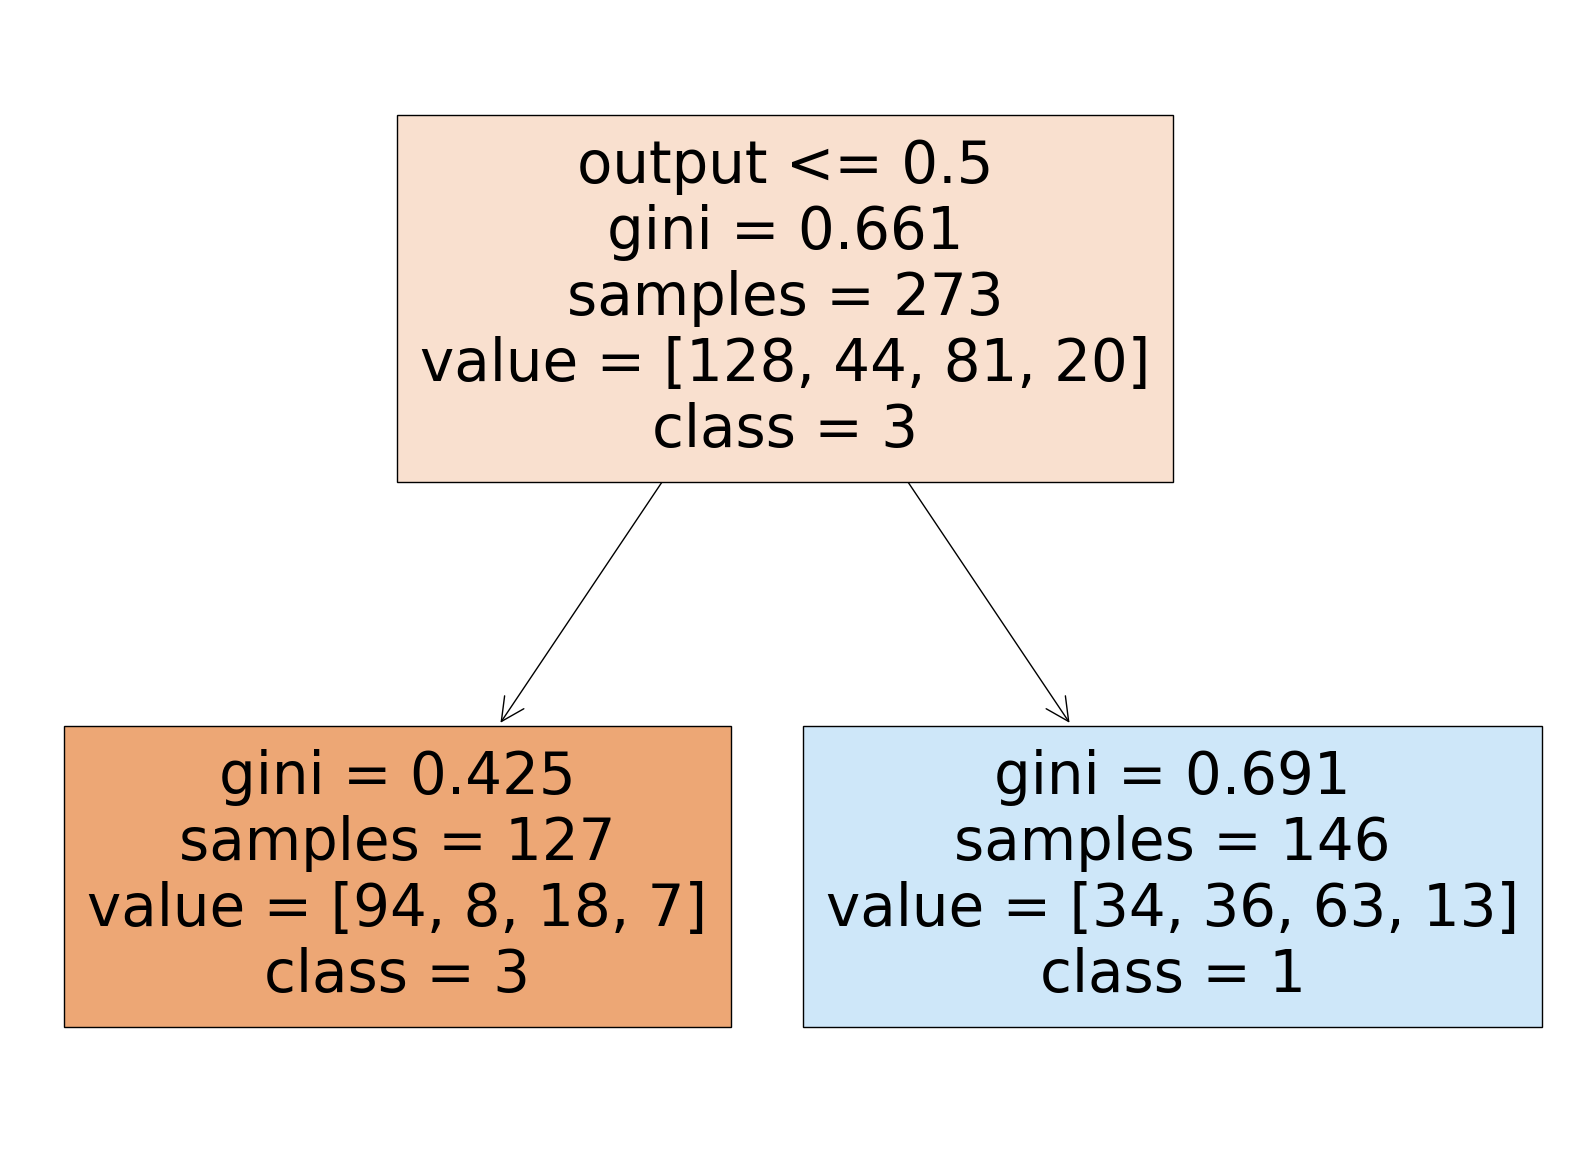

In [37]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

unique_classes = ha['cp'].unique()
class_names = [str(class_label) for class_label in unique_classes]

# Visualize the decision tree
fig = plt.figure(figsize=(20, 15))
_ = plot_tree(tree_pipeline.named_steps['tree_classifier'],
              feature_names=X.columns,
              class_names=class_names,
              filled=True)
plt.show()

DT Interpretation:

The first node looks at the whole dataset. The model first predits for either output of disease (1) or no disease (0). The model predicts best for distinghuing between Category 1 and Category 3.

LDA

In [38]:
LDA_pipeline = Pipeline(
  [
      ("preprocessing", ct2),
      ("LDA", LinearDiscriminantAnalysis())]
)

# Fit and predict
LDA_pipeline.fit(X, y)
y_pred_LDA = cross_val_predict(LDA_pipeline, X, y, cv=5)

accuracy = accuracy_score(y, y_pred_LDA)
print(accuracy)

0.5421245421245421


## Q2:  OvR

Create a new column in the `ha` dataset called `cp_is_3`, which is equal to `1` if the `cp` variable is equal to `3` and `0` otherwise.

Then, fit a Logistic Regression to predict this new target, and report the **F1 Score**.

Repeat for the other three `cp` categories.  Which category was the OvR approach best at distinguishing?

for 0, it is good at determining (could mean there are more 0 than any other category)

- 0 means it's asympotic (no chest pain), easier to distih whether or not with pain rather than type of pain
- 0 is a stnadout class (1-3 are types of pain)
- 1 and 3 have bad scores (score=0), because it is always predicting R (the rest), not good but not mathematically wrong
- when there is imbalaced categpry, we face this issue
- this a flaw in OvR and this means we gotta follow up with why it did not predict well

Category 3

In [39]:
# New columns
ha['cp_is_3'] = (ha['cp'] == 3).astype(int)

# X and y split
X = ha.drop(['cp', 'cp_is_3'], axis=1)  # Exclude 'cp' and the new target
y = ha['cp_is_3']

In [40]:
log_pipeline = Pipeline(
  [
      ("preprocessing", ct2),
      ("log_regression", LogisticRegression())]
)

param = {
    'log_regression__C': np.logspace(-4, 4, 20),
    'log_regression__penalty': ['l1', 'l2']
}

# Define GridSearchCV
gscv = GridSearchCV(log_pipeline, param, cv=5, scoring='f1_macro')

# Fit the GridSearchCV object
gscv_fitted = gscv.fit(X, y)

# Get the best score and the best parameters
best_score = gscv_fitted.best_score_
best_params = gscv_fitted.best_params_

best_score, best_params

(0.48098693759071115,
 {'log_regression__C': 0.0001, 'log_regression__penalty': 'l2'})

In [41]:
log_pipeline = Pipeline(
  [
      ("preprocessing", ct2),
      ("log_regression", LogisticRegression(penalty='l2', C=0.0001))]
)

# Fit and predict
log_fitted = log_pipeline.fit(X, y)
y_pred_log3 = log_fitted.predict(X)

y_pred_log3

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

Category 2

In [44]:
# New columns
ha['cp_is_2'] = (ha['cp'] == 2).astype(int)

# X and y split
X = ha.drop(['cp', 'cp_is_2', 'cp_is_3'], axis=1)  # Exclude 'cp' and the new target
y = ha['cp_is_2']

In [45]:
log_pipeline = Pipeline(
  [
      ("preprocessing", ct2),
      ("log_regression", LogisticRegression())]
)

param = {
    'log_regression__C': np.logspace(-4, 4, 20),
    'log_regression__penalty': ['l1', 'l2']
}

# Define GridSearchCV
gscv = GridSearchCV(log_pipeline, param, cv=5, scoring='f1_macro')

# Fit the GridSearchCV object
gscv_fitted = gscv.fit(X, y)

# Get the best score and the best parameters
best_score = gscv_fitted.best_score_
best_params = gscv_fitted.best_params_

best_score, best_params

(0.4425522722768466,
 {'log_regression__C': 0.23357214690901212, 'log_regression__penalty': 'l2'})

In [46]:
log_pipeline = Pipeline(
  [
      ("preprocessing", ct2),
      ("log_regression", LogisticRegression(penalty= 'l2', C=0.23357214690901212))]
)

# Fit and predict
log_fitted2 = log_pipeline.fit(X, y)
y_pred_log2 = log_fitted2.predict(X)

y_pred_log2

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

Category 1

In [48]:
# New columns
ha['cp_is_1'] = (ha['cp'] == 1).astype(int)

# X and y split
X = ha.drop(['cp', 'cp_is_1', 'cp_is_2', 'cp_is_3'], axis=1)  # Exclude 'cp' and the new target
y = ha['cp_is_1']

In [49]:
log_pipeline = Pipeline(
  [
      ("preprocessing", ct2),
      ("log_regression", LogisticRegression())]
)

param = {
    'log_regression__C': np.logspace(-4, 4, 20),
    'log_regression__penalty': ['l1', 'l2']
}

# Define GridSearchCV
gscv = GridSearchCV(log_pipeline, param, cv=5, scoring='f1_macro')

# Fit the GridSearchCV object
gscv_fitted = gscv.fit(X, y)

# Get the best score and the best parameters
best_score = gscv_fitted.best_score_
best_params = gscv_fitted.best_params_

best_score, best_params

(0.45617641764176414,
 {'log_regression__C': 0.0001, 'log_regression__penalty': 'l2'})

In [50]:
log_pipeline = Pipeline(
  [
      ("preprocessing", ct2),
      ("log_regression", LogisticRegression(penalty= 'l2', C=0.0001))]
)

# Fit and predict
log_fitted1 = log_pipeline.fit(X, y)
y_pred_log1 = log_fitted1.predict(X)

y_pred_log1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

Category 0

In [51]:
# Creating the new column for cp_is_0
ha['cp_is_0'] = (ha['cp'] == 0).astype(int)

# Splitting the data
X = ha.drop(['cp', 'cp_is_0', 'cp_is_1', 'cp_is_2', 'cp_is_3'], axis=1)  # Exclude 'cp' and the new target
y = ha['cp_is_0']

In [52]:
log_pipeline = Pipeline(
  [
      ("preprocessing", ct2),
      ("log_regression", LogisticRegression())]
)

param = {
    'log_regression__C': np.logspace(-4, 4, 20),
    'log_regression__penalty': ['l1', 'l2']
}

# Define GridSearchCV
gscv = GridSearchCV(log_pipeline, param, cv=5, scoring='f1_macro')

# Fit the GridSearchCV object
gscv_fitted = gscv.fit(X, y)

# Get the best score and the best parameters
best_score = gscv_fitted.best_score_
best_params = gscv_fitted.best_params_

best_score, best_params

(0.6653307662801333,
 {'log_regression__C': 206.913808111479, 'log_regression__penalty': 'l2'})

In [53]:
log_pipeline = Pipeline(
  [
      ("preprocessing", ct2),
      ("log_regression", LogisticRegression(penalty= 'l2', C=206.913808111479))]
)

# Fit and predict
log_fitted0 = log_pipeline.fit(X, y)
y_pred_log0 = log_fitted0.predict(X)

y_pred_log0

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1])

## Q3: OvO

Reduce your dataset to only the `0` and `1` types of chest pain.

Then, fit a Logistic Regression to predict between the two groups, and report the **ROC-AUC**.  

Repeat comparing category `0` to `2` and `3`.  Which pair was the OvO approach best at distinguishing?

0 and 1 types of chest pain

In [54]:
# Filter the dataset to include only rows with cp values 0 or 1
ha_filtered = ha[ha['cp'].isin([0, 1])]

# X and y split
X = ha_filtered.drop(['cp', 'cp_is_0', 'cp_is_1', 'cp_is_2', 'cp_is_3'], axis=1)  # Exclude 'cp' and the new target
y = ha_filtered['cp']

In [55]:
log_pipeline1 = Pipeline(
  [
      ("preprocessing", ct2),
      ("log_regression", LogisticRegression())]
)

param = {
    'log_regression__C': np.logspace(-4, 4, 20),
    'log_regression__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1]
}

# Define GridSearchCV
gscv = GridSearchCV(log_pipeline1, param, cv=5, scoring='roc_auc_ovo')

# Fit the GridSearchCV object
gscv_fitted = gscv.fit(X, y)

# Get the best score and the best parameters
best_score = gscv_fitted.best_score_
best_params = gscv_fitted.best_params_

best_score, best_params  # ROC_AUC ovo score of 0.8368974358974359

(0.8368974358974359,
 {'log_regression__C': 1.623776739188721, 'log_regression__l1_ratio': 0.1})

0 and 2 types of chest pain

In [58]:
# Filter the dataset to include only rows with cp values 0 or 2
ha_filtered = ha[ha['cp'].isin([0, 2])]

# X and y split
X = ha_filtered.drop(['cp', 'cp_is_0', 'cp_is_1', 'cp_is_2', 'cp_is_3'], axis=1)  # Exclude 'cp' and the new target
y = ha_filtered['cp']

In [59]:
log_pipeline = Pipeline(
  [
      ("preprocessing", ct2),
      ("log_regression", LogisticRegression())]
)

param = {
    'log_regression__C': np.logspace(-4, 4, 20),
    'log_regression__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1]
}

# Define GridSearchCV
gscv = GridSearchCV(log_pipeline, param, cv=5, scoring='roc_auc_ovo')

# Fit the GridSearchCV object
gscv_fitted = gscv.fit(X, y)

# Get the best score and the best parameters
best_score = gscv_fitted.best_score_
best_params = gscv_fitted.best_params_

best_score, best_params # ROC_AUC ovo score of 0.7569954751131223

(0.7569954751131223,
 {'log_regression__C': 78.47599703514607, 'log_regression__l1_ratio': 0.1})

0 and 3 types of chest pain

In [60]:
# Filter the dataset to include only rows with cp values 0 or 3
ha_filtered = ha[ha['cp'].isin([0, 3])]

# X and y split
X = ha_filtered.drop(['cp', 'cp_is_0', 'cp_is_1', 'cp_is_2', 'cp_is_3'], axis=1)  # Exclude 'cp' and the new target
y = ha_filtered['cp']

In [61]:
log_pipeline = Pipeline(
  [
      ("preprocessing", ct2),
      ("log_regression", LogisticRegression())]
)

param = {
    'log_regression__C': np.logspace(-4, 4, 20),
    'log_regression__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1]
}

# Define GridSearchCV
gscv = GridSearchCV(log_pipeline, param, cv=5, scoring='roc_auc')

# Fit the GridSearchCV object
gscv_fitted = gscv.fit(X, y)

# Get the best score and the best parameters
best_score = gscv_fitted.best_score_
best_params = gscv_fitted.best_params_

best_score, best_params  # ROC_AUC ovo score of 0.7392307692307692

(0.7392307692307692,
 {'log_regression__C': 4.281332398719396, 'log_regression__l1_ratio': 0.1})

OvO approach works best for looking at categories 0 and 1.

This makes sense because by the nature of the metric it is easy to say "you do have pain" or "you do not have pain".
